In [27]:
import cv2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time

import sys
sys.path.append('../../')
from core import *
from utils import channelSplit
init('../../cmap.csv')

#starttime=time()

In [33]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = .2

In [34]:
def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score.
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches.
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches.
    #imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    #cv2.imwrite("matches.jpg", imMatches)
    
    # Extract location of good matches.
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt


    #print("Points 1", points1) 
    #print("Points 2", points2) 

    # Find homography.
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography.
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    #shiftXY, error, diffphase = register_translation(Rimg, NIRoff) 

    # Shifts first element by second element amount
    #NIRimg = shift(NIRoff, np.array(shiftXY))
    #NDVIimg = ndvi_map(Rimg, NIRimg)

    # Plot NDVI ColorMapped Image
    #plt.imshow(NDVIimg)
    #plt.axis('off')
    #plt.title('NDVI ColorMapped Image')

    return im1Reg, h

Opening reference image :  ../Images/RGB.png
Opening image to align :  ../Images/NGB.png

Orignal images had dimensions:  (660, 860)

Time to register= 0.06046152114868164 s
Time to map= 0.03516197204589844 s
Total time to process= 0.09562349319458008 s


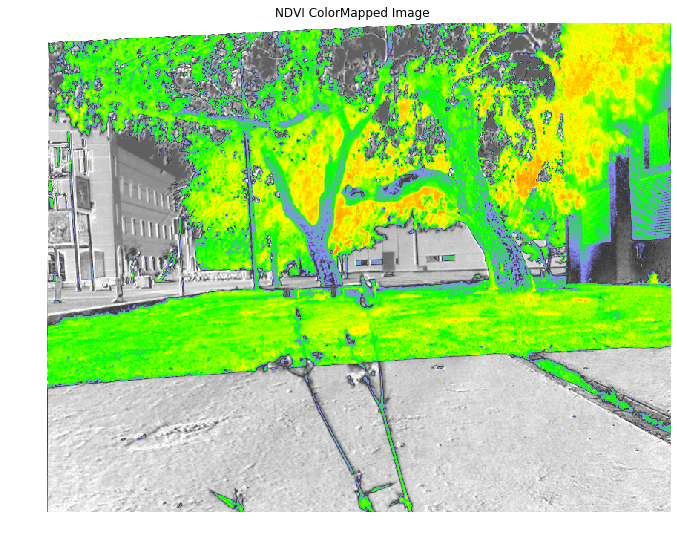

In [35]:
if __name__ == '__main__':

    # Read reference image
    #refFilename = 'Documents/Poster.jpg'
    refFilename='../Images/RGB.png'
    print("Opening reference image : ", refFilename)
    imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
    #[b, g, r] = cv2.split(imReference)

    # Read image to be aligned
    #imFilename = 'Documents/Poster2.jpg'
    imFilename = '../Images/NGB.png'
    print("Opening image to align : ", imFilename);  
    im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
    #[b2, g2, r2] = cv2.split(im)

    #Rimg = r #red pixel set from pi camera
    #NIRoff = r2 #NIR pixel set from NOIR camera

    # Registered image will be restored in imReg. 
    # The estimated homography will be stored in h.
    starttime = time()
    imReg, h = alignImages(im, imReference)
    t_reg = time()-starttime # Time tracking of registration
    regtime = time()

    #color map with Jessi's registered images
    [b, g, Rimg] = cv2.split(imReference)
    [b, g, NIRimg] = cv2.split(imReg)
    NDVIimg = ndvi_map(Rimg, NIRimg)
    t_map = time() - regtime # Time tracking of color mapping


    # Display Results
    print('\nOrignal images had dimensions: ', Rimg.shape)
    print("\nTime to register= "+ str(t_reg) +" s")
    print("Time to map= "+ str(t_map) +" s")
    print("Total time to process=", t_map+t_reg, "s")
    
    # Plot NDVI ColorMapped Image
    plt.figure(figsize=(12,9))
    plt.imshow(NDVIimg)
    plt.axis('off')
    plt.title('NDVI ColorMapped Image')
    
    # Write aligned image to disk. 
    #outFilename = "../Images/aligned.jpg"
    #print("Saving Aligned image : ", outFilename); 
    #cv2.imwrite(outFilename, imReg)
 
    # Print estimated homography
    #print("Estimated homography : \n",  h)

In [ ]:
# Show images in new windows
image1 = Image.open('Documents/Github:Python/PlantHealth/planthealth/tests/Images/RGB.png')
image1.show()
image2 = Image.open('Documents/Github:Python/PlantHealth/planthealth/tests/Images/NGB.png')
image2.show()
aligned = Image.open('aligned.jpg')
aligned.show()
matches= Image.open('matches.jpg')
matches.show()